# 5.3 전이학습

In [ ]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision # 컴퓨터 비전 용도의 패키지
import torchvision.transforms as transforms # 데이터 전처리 패키지
import torchvision.models as models # 다양한 파이토치 네트워크
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
file_uploaded = files.upload()

Saving catanddog.zip to catanddog.zip


In [ ]:
cd /content/drive/MyDrive/Eurone/Week4/catanddog.zip

/content/drive/MyDrive/Eurone/Week4/catanddog.zip


In [ ]:
!pwd

/content/drive/MyDrive/Eurone/Week4/catanddog.zip


In [ ]:
!unzip catanddog.zip -d catanddog/

Archive:  catanddog.zip
replace catanddog/test/Cat/8100.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: catanddog/test/Cat/8100.jpg  
replace catanddog/test/Cat/8101.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: catanddog/test/Cat/8101.jpg  
replace catanddog/test/Cat/8102.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: catanddog/test/Cat/8102.jpg  
replace catanddog/test/Cat/8103.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: catanddog/test/Cat/8103.jpg  
replace catanddog/test/Cat/8104.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: catanddog/test/Cat/8104.jpg  
replace catanddog/test/Cat/8105.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: catanddog/test/Cat/8105.jpg  
replace catanddog/test/Cat/8106.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: catanddog/test/Cat/8106.jpg  
replace catanddog/test/Cat/8107.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: catanddog/test/Cat/8107.jpg  
replace catanddo

In [ ]:
# 이미지 데이터 전처리 방법
data_path = 'catanddog/train/'

# 이미지 데이터를 모델(네트워크)의 입력으로 사용하도록 변환
transform = transforms.Compose(
    [
        transforms.Resize([256,256]), # 이미지 크기 조정
        transforms.RandomResizedCrop(224), # 이미지를 랜덤한 비율로 자른 후 데이터 크기를 조정(데이터 확장 용도)
        transforms.RandomHorizontalFlip(), # 이미지를 랜덤하게 수평으로 뒤집음
        transforms.ToTensor() # 이미지 데이터를 텐서로 변환
    ]
)
train_dataset = torchvision.datasets.ImageFolder(data_path, transform = transform)

# 데이터 로더에 할당
train_loader = torch.utils.data.DataLoader(
    train_dataset, # 데이터셋 지정
    batch_size=32, # 한 번에 불러올 데이터의 양 결정
    num_workers=8, # 데이터 불러올 때 사용할 하위 프로세스의 개수
    shuffle=True # 무작위로 섞을지 지정
)

print(len(train_dataset))

385


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


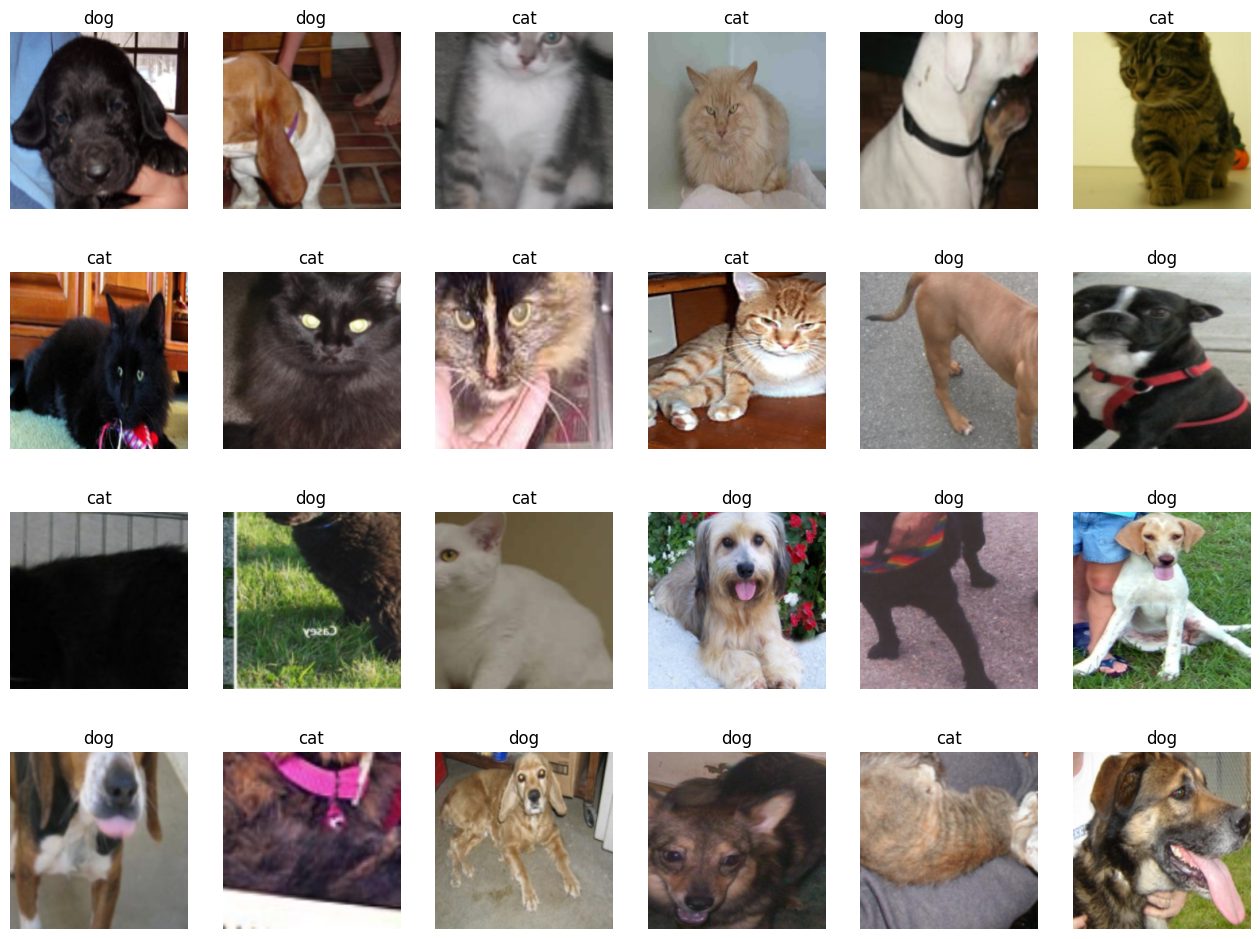

In [ ]:
# 학습에 이용될 이미지 출력

import numpy as np

data_iter = iter(train_loader)
samples, labels = next(data_iter) #next(iter(train_loader))

# samples, labels = iter(train_loader).next() <- 책 코드(잘못된 방식?)

classes = {0:'cat', 1:'dog'} # 개와 고양이에 대한 클래스
fig = plt.figure(figsize=(16,24))

# 24개의 이미지 데이터 출력
for i in range(24):
    a = fig.add_subplot(4, 6, i+1)
    a.set_title(classes[labels[i].item()]) # 레이블 정보를 함께 출력
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0))) # 행렬의 차원을 바꿈
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)


**반복자**

*   iter(): 전달된 데이터의 반복자를 꺼내 반환
*   next(): 그 반복자가 다음에 출력해야할 요소 반환


**행령 차원 변경**
: 행렬의 내적 연산 때문




In [ ]:
# 사전 훈련된 모델 내려받기
resnet18 = models.resnet18(pretrained=True)
# 사전 학습된 가중치를 사용하겠다는 의미

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 173MB/s]


In [ ]:
# 사전 훈련된 모델의 파라미터 학습 유무 지정
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False # 역전파 중 파라미터들에 대한 변화를 계산할 필요 없음

set_parameter_requires_grad(resnet18)

In [ ]:
# ResNet18에 완전연결층 추가
resnet18.fc = nn.Linear(512,2) # 2는 클래스가 두 개임을 의미

In [ ]:
# 모델의 파라미터 값 확인
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[ 0.0401, -0.0333, -0.0413,  ...,  0.0293,  0.0044,  0.0300],
        [ 0.0393, -0.0179, -0.0084,  ..., -0.0060,  0.0013, -0.0172]])
fc.bias tensor([0.0269, 0.0406])


model.named_parameters()는 모델에 접근하여 파라미터 값들을 가져올 때 사용

*   fc.weight : Fully Connectd Layer의 가중치 행렬로
    
    - 크기: (출력 뉴런 수, 입력 뉴런수) 형태

    - 가중치 행렬의 일부 값이 tesnsor([...]) 형식으로 표시되며, 작은 실수값들은 모델이 학습되면서 변할 수 있는 값들


*   fc. bias: Fully Connected Layer의 편향(Bias) 벡터로
    - 크기: (출력 뉴런 수, ), 출력 뉴런마다 하나의 편향값이 존재



In [ ]:
# 모델 객체 생성 및 손실 함수 정의
model = models.resnet18(pretrained=True) # 모델의 객체 생성

for param in model.parameters(): # 모델의 합성곱층 가중치 고정
    param.requires_grad = False

model.fc = torch.nn.Linear(512,2)
for param in model.fc.parameters(): # 완전연결층은 학습
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# 모델 학습을 위한 함수 생성
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13,
                is_train=True):
    since = time.time() # 컴퓨터의 현재 시각을 구하는 함수
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-'*10)

        running_loss = 0.0
        running_corrects=0

        for inputs, labels in dataloaders: #데이터로더에 전달된 데이터만큼 반복
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad() # 기울기를 0으로 설정
            outputs = model(inputs) # 순전파 학습
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward() # 역전파 학습
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            # 출력 결과와 레이블의 오차를 계산한 결과를 누적하여 저장
            running_corrects += torch.sum(preds == labels.data)
            # 출력 결과와 레이블이 동일한지 확인한 결과를 누적하여 계산

        epoch_loss = running_loss / len(dataloaders.dataset) # 평균 오차 계산
        epoch_acc = running_corrects.double() / len(dataloaders.dataset) # 평균 정확도 계산

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('catanddog/', '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed = time.time() - since # 실행 시간(학습 시간)을 계산
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60,
                                                        time_elapsed % 60))
    print('Best Acc:{:4f}'.format(best_acc))
    return acc_history, loss_history # 모델의 정확도와 오차를 반환


In [ ]:
# 파라미터 학습 결과를 옵티마이저에 전달
params_to_update = []
for name, param in resnet18.named_parameters():
    if param.requires_grad==True:
        params_to_update.append(param)
        print("\t", name)
optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


In [ ]:
# 모델 학습
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss() # 손실 함수 지정
train_acc_hist, trian_loss_hist = train_model(resnet18, train_loader, criterion,
                                              optimizer, device)

Epoch 0/12
----------
Loss: 0.5435 Acc: 0.7143

Epoch 1/12
----------
Loss: 0.3652 Acc: 0.8338

Epoch 2/12
----------
Loss: 0.3126 Acc: 0.8831

Epoch 3/12
----------
Loss: 0.2719 Acc: 0.8857

Epoch 4/12
----------
Loss: 0.2381 Acc: 0.9221

Epoch 5/12
----------
Loss: 0.3078 Acc: 0.8623

Epoch 6/12
----------
Loss: 0.2329 Acc: 0.9091

Epoch 7/12
----------
Loss: 0.2343 Acc: 0.9065

Epoch 8/12
----------
Loss: 0.1884 Acc: 0.9299

Epoch 9/12
----------
Loss: 0.2302 Acc: 0.8857

Epoch 10/12
----------
Loss: 0.1957 Acc: 0.9221

Epoch 11/12
----------
Loss: 0.1989 Acc: 0.9169

Epoch 12/12
----------
Loss: 0.1738 Acc: 0.9351

Training complete in 1m 41s
Best Acc:0.935065


In [ ]:
# 테스트 데이터 호출 및 전처리

test_path = 'catanddog/test/'

transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)
test_dataset = torchvision.datasets.ImageFolder(
    root = test_path,
    transform=transform
)
test_loader  = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = 32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

98


In [ ]:
# 테스트 데이터 평가 함수 생성
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('catanddog/'+'*.pth')
    saved_models.sort() # 불러온 .pth
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects=0

        for inputs, labels in dataloaders: # 테스트 반복
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad(): #autograd 사용 X
                outputs=model(inputs) # 데이터를 모델에 적용한 결과를 outputs에 저장

            _,preds = torch.max(outputs.data,1)
            preds[preds>=0.5] =1
            preds[preds<0.5] = 0
            running_corrects += preds.eq(labels.to(device)).int().sum()

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed//60,
                                                          time_elapsed%60))
    print('Best Acc: {:.4f}'.format(best_acc))

    return acc_history #계산된 정확도 반환


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# 테스트 데이터를 평가 함수에 적용
val_acc_hist = eval_model(resnet18, test_loader, device)


saved_model ['catanddog/00.pth', 'catanddog/01.pth', 'catanddog/02.pth', 'catanddog/03.pth', 'catanddog/04.pth', 'catanddog/05.pth', 'catanddog/06.pth', 'catanddog/07.pth', 'catanddog/08.pth', 'catanddog/09.pth', 'catanddog/10.pth', 'catanddog/11.pth', 'catanddog/12.pth']
Loading model catanddog/00.pth
Acc: 0.8980

Loading model catanddog/01.pth
Acc: 0.9184

Loading model catanddog/02.pth
Acc: 0.9388

Loading model catanddog/03.pth
Acc: 0.9388

Loading model catanddog/04.pth
Acc: 0.9490

Loading model catanddog/05.pth
Acc: 0.9286

Loading model catanddog/06.pth
Acc: 0.9388

Loading model catanddog/07.pth
Acc: 0.9388

Loading model catanddog/08.pth
Acc: 0.9286

Loading model catanddog/09.pth
Acc: 0.9490

Loading model catanddog/10.pth
Acc: 0.9490

Loading model catanddog/11.pth
Acc: 0.9490

Loading model catanddog/12.pth
Acc: 0.9388

Validation complete in 0m 31s
Best Acc: 0.9490


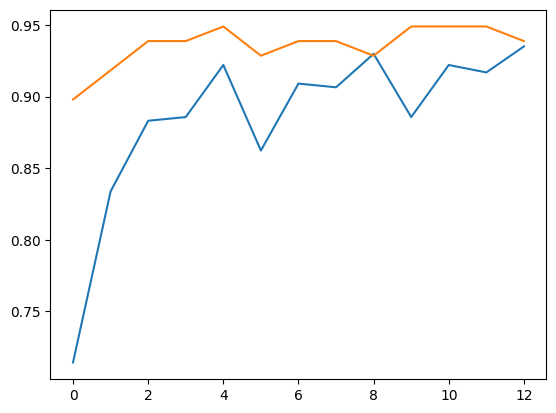

In [ ]:
# 훈련과 테스트 데이터의 정확도를 그래프로 확인
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

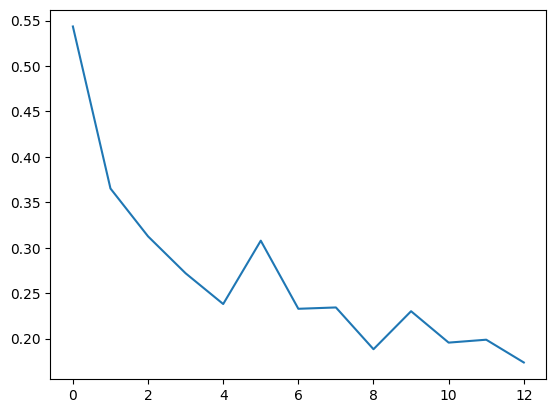

In [ ]:
# 훈련 데이터의 오차에 대한 그래프 확인
plt.plot(trian_loss_hist)
plt.show()

In [ ]:
# 예측 이미지를 위한 전처리 함수

def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1,2,0)
    image = image * (np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5)))
    image = image.clip(0,1)
    return image

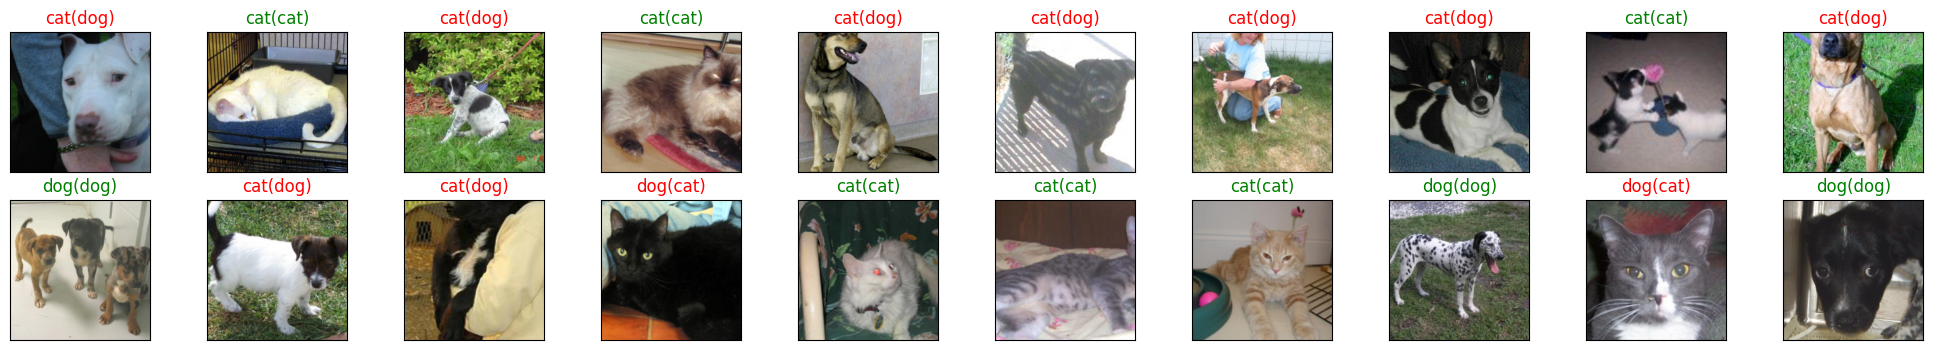

<Figure size 640x480 with 0 Axes>

In [ ]:
# 개와 고양이 예측 결과 출력

classes = {0:'cat', 1:'dog'}

dataiter = iter(test_loader)
images, labels = next(dataiter)

ouput = model(images)
_,preds=torch.max(ouput,1)

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()]))
,color=("green" if preds[idx]==labels[idx] else "red"))

plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

# 5.4 설명 가능한 CNN

In [ ]:
pip install pillow

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

5.4.1 특성맵 시각화
-> 특성 맵에서 입력 특성을 감지하는 방법을 이해할 수 있도록 도움

In [2]:
# 설명 가능한 네트워크 생성

class XAI(torch.nn.Module):
    def __init__(self, num_classes=2):
        super(XAI, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier=nn.Sequential(
            nn.Linear(512,512, bias=False),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512,num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1,512)
        x = self.classifier(x)
        return F.log_softmax(x)

In [3]:
# 모델 객체화
model = XAI() # model이라는 이름의 객체를 생성
model.to(device) # model을 장치에 할당
model.eval() # 테스트 데이터에 대한 모델 편가 용도로 사용

XAI(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True)
    (15): MaxP

In [4]:
# 특성 맵을 확인하기 위한 클래스 정의
class LayerActivations:
    features=[]
    def __init__(self, model, layer_num):
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = output.detach().numpy()
    def remove(self): # hook 삭제
        self.hook.remove()

Saving cat.jpg to cat.jpg
torch.Size([1, 3, 100, 100])


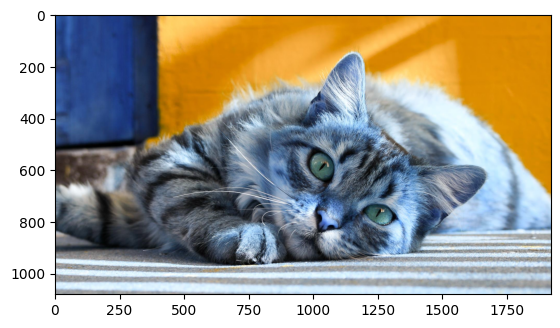

In [5]:
# 이미지 호출

from google.colab import files
file_uploaded = files.upload()

img = cv2.imread("cat.jpg")
plt.imshow(img)
img = cv2.resize(img, (100,100), interpolation=cv2.INTER_AREA)
img = ToTensor()(img).unsqueeze(0)
print(img.shape)

In [6]:
# 모델 디바이스에 올리기
model = model.to(device)

# 입력 이미지도 디바이스로!
img = img.to(device)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Conv2d 특성 맵 확인
result = LayerActivations(model.features, 0) # 0번째 Conv2d 특성 맵 확인

model(img)
activations = result.features

<ipython-input-2-6c63e7f83057>:71: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


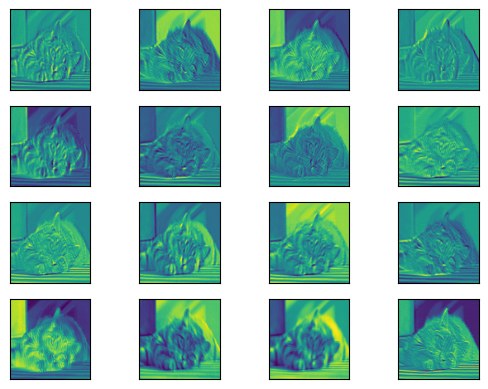

<Figure size 1200x800 with 0 Axes>

In [8]:
# 특성 맵 확인
fig, axes = plt.subplots(4,4)
fig= plt.figure(figsize = (12,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*4+column])
plt.show()

In [9]:
# 20번째 계층에 대한 특성 맵
result = LayerActivations(model.features, 20) # 20번째 Conv2d 특성 맵 확인

model(img)
activations = result.features

<ipython-input-2-6c63e7f83057>:71: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


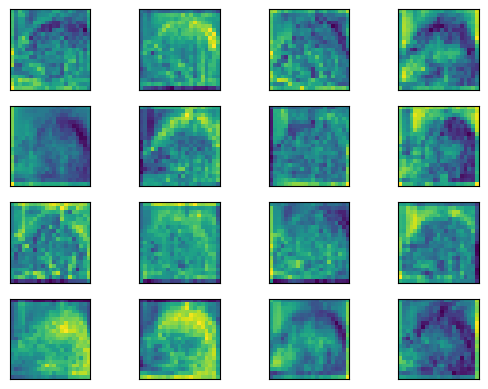

<Figure size 1200x800 with 0 Axes>

In [10]:
# 특성 맵 확인

# 특성 맵 확인
fig, axes = plt.subplots(4,4)
fig= plt.figure(figsize = (12,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()

In [11]:
# 40번째 계층에 대한 특성 맵

result = LayerActivations(model.features, 40) # 40번째 Conv2d 특성 맵 확인

model(img)
activations = result.features

<ipython-input-2-6c63e7f83057>:71: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


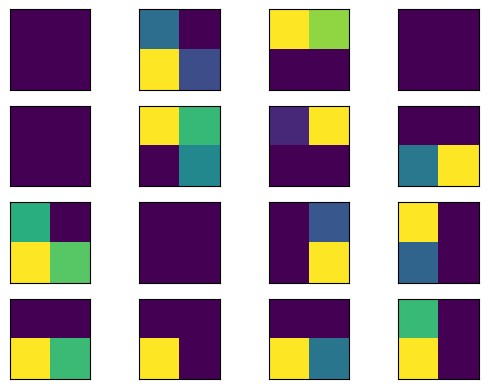

<Figure size 1200x800 with 0 Axes>

In [13]:
# 특성 맵 확인
fig, axes = plt.subplots(4,4)
fig= plt.figure(figsize = (12,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()